<a href="https://colab.research.google.com/github/akouaouchissam/sparkNLP/blob/main/predict_nextday_healthcare_features_from_clinical_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json

from google.colab import files

license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

Saving spark_nlp_for_healthcare.json to spark_nlp_for_healthcare (1).json


In [ ]:
license_keys['JSL_VERSION']

'3.0.2'

In [ ]:
license_keys['PUBLIC_VERSION']

'3.0.2'

In [ ]:
! java -version

openjdk version "1.8.0_292"
OpenJDK Runtime Environment (build 1.8.0_292-8u292-b10-0ubuntu1~18.04-b10)
OpenJDK 64-Bit Server VM (build 25.292-b10, mixed mode)


In [ ]:
%%capture
for k,v in license_keys.items(): 
    %set_env $k=$v

!bash jsl_colab_setup.sh

! pip install spark-nlp-display

In [ ]:
import json
import os
from pyspark.ml import Pipeline,PipelineModel
from pyspark.sql import SparkSession

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl
import sparknlp

params = {"spark.driver.memory":"16G",
"spark.kryoserializer.buffer.max":"2000M",
"spark.driver.maxResultSize":"2000M"}

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

print ("Spark NLP Version :", sparknlp.version())
print ("Spark NLP_JSL Version :", sparknlp_jsl.version())

Spark NLP Version : 3.0.2
Spark NLP_JSL Version : 3.0.2


In [ ]:
! pyspark --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.1.1
      /_/
                        
Using Scala version 2.12.10, OpenJDK 64-Bit Server VM, 1.8.0_292
Branch HEAD
Compiled by user ubuntu on 2021-02-22T01:33:19Z
Revision 1d550c4e90275ab418b9161925049239227f3dc9
Url https://github.com/apache/spark
Type --help for more information.


#Loading the CSV file

In [ ]:
import pandas as pd
df = pd.read_csv('mimic_100_pats.csv', sep=',')
df = df[['CHARTDATE', 'TEXT']]
df = df.rename(columns={"TEXT": "text", "CHARTDATE": 'date'})

In [ ]:
spark_df = spark.createDataFrame(df[:40])

In [ ]:
spark_df.show()

+----------+--------------------+
|      date|                text|
+----------+--------------------+
|2191-05-10|Admission Date:  ...|
|2126-05-22|Admission Date:  ...|
|2127-07-29|Admission Date:  ...|
|2108-03-13|Admission Date:  ...|
|2147-12-11|Admission Date:  ...|
|2157-12-02|Admission Date:  ...|
|2180-08-31|Admission Date:  ...|
|2180-10-29|Admission Date:  ...|
|2181-02-27|Admission Date:  ...|
|2100-09-24|Admission Date:  ...|
+----------+--------------------+



# NER Pipeline

defining the sparkNLP pipeline to extract features from the text data using pretrained models in our case we will use 5 models:



1.   ner_clinical: Detect signs and symptoms
2.   ner_diseases: Detect diagnosis and procedures
3.   ner_posology: Detect drugs and prescriptions
4.   ner_jsl: Detect lab results
5.   ner_risk_factors: Detect risk factors

In [ ]:
documentAssembler = DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")

# Sentence Detector
sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
        .setInputCols(["document"])\
        .setOutputCol("sentence")
 
# splits words
tokenizer = Tokenizer()\
        .setInputCols(["sentence"])\
        .setOutputCol("token")

# Clinical word embeddings
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical","en","clinical/models")\
        .setInputCols(["sentence","token"])\
        .setOutputCol("embeddings")

# NER model
clinical_ner1 = MedicalNerModel.pretrained("ner_clinical","en","clinical/models")\
        .setInputCols(["sentence","token","embeddings"])\
        .setOutputCol("ner1")

clinical_ner2 = MedicalNerModel.pretrained("ner_diseases", "en", "clinical/models") \
.setInputCols(["sentence", "token", "embeddings"])\
.setOutputCol("ner2")

clinical_ner3 = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models") \
.setInputCols(["sentence", "token", "embeddings"])\
.setOutputCol("ner3")

clinical_ner4 = MedicalNerModel.pretrained("ner_jsl", "en", "clinical/models") \
.setInputCols(["sentence", "token", "embeddings"])\
.setOutputCol("ner4")

clinical_ner5 = MedicalNerModel.pretrained("ner_risk_factors", "en", "clinical/models") \
.setInputCols(["sentence", "token", "embeddings"])\
.setOutputCol("ner5")

ner_converter1 = NerConverter()\
        .setInputCols(["sentence","token","ner1"])\
        .setOutputCol("ner_chunk1")

ner_converter2 = NerConverter()\
        .setInputCols(["sentence","token","ner2"])\
        .setOutputCol("ner_chunk2")

ner_converter3 = NerConverter()\
        .setInputCols(["sentence","token","ner3"])\
        .setOutputCol("ner_chunk3")

ner_converter4 = NerConverter()\
        .setInputCols(["sentence","token","ner4"])\
        .setOutputCol("ner_chunk4")

ner_converter5 = NerConverter()\
        .setInputCols(["sentence","token","ner5"])\
        .setOutputCol("ner_chunk5")

features_embeddings = WordEmbeddingsModel.pretrained()\
    .setInputCols("sentence","token","ner_chunk1", "ner_chunk2", "ner_chunk3", "ner_chunk4", "ner_chunk5") \
    .setOutputCol("features")


nlpPipeline = Pipeline(stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        clinical_ner1,
        clinical_ner2,
        clinical_ner3,
        clinical_ner4,
        clinical_ner5,
        ner_converter1,
        ner_converter2,
        ner_converter3,
        ner_converter4,
        ner_converter5,
        features_embeddings])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
ner_diseases download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
ner_posology download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
ner_jsl download started this may take some time.
Approximate size to download 14 MB
[OK!]
ner_risk_factors download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [ ]:
model.stages

[DocumentAssembler_cc3e3ecfc65a,
 SentenceDetectorDLModel_d2546f0acfe2,
 REGEX_TOKENIZER_4c35233e0cd9,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 MedicalNerModel_cd5ce67b529f,
 MedicalNerModel_de8a6553ccd1,
 MedicalNerModel_4a303d875127,
 MedicalNerModel_780111584534,
 MedicalNerModel_e9b29204bb73,
 NerConverter_e9a12abc6ac1,
 NerConverter_622f3c5352bd,
 NerConverter_ca758920a8a8,
 NerConverter_f5590810c1c2,
 NerConverter_ac3499a180a4,
 WORD_EMBEDDINGS_MODEL_48cffc8b9a76]

In [ ]:
clinical_ner4.getClasses()

['O',
 'I-Drug_Name',
 'B-Dosage',
 'I-Dosage',
 'B-Frequency',
 'I-Frequency',
 'B-Drug_Name',
 'B-Modifier',
 'B-Diagnosis',
 'B-Lab_Name',
 'I-Lab_Name',
 'B-Route',
 'I-Route',
 'B-Symptom_Name',
 'B-Procedure_Name',
 'I-Procedure_Name',
 'I-Diagnosis',
 'B-Name',
 'I-Name',
 'B-Negated',
 'B-Age',
 'B-Gender',
 'I-Modifier',
 'I-Symptom_Name',
 'B-Section_Name',
 'I-Section_Name',
 'B-Negation',
 'B-Allergenic_substance',
 'I-Negation',
 'I-Allergenic_substance',
 'B-Procedure_Findings',
 'B-Cause_of_death',
 'I-Cause_of_death',
 'B-Lab_Result',
 'B-Maybe',
 'B-Substance_Name',
 'B-Blood_Pressure',
 'I-Age',
 'I-Lab_Result',
 'I-Maybe',
 'B-Temperature',
 'B-Drug_incident_description',
 'I-Drug_incident_description',
 'I-Blood_Pressure',
 'B-Causative_Agents_(Virus_and_Bacteria)',
 'B-Pulse_Rate',
 'I-Gender',
 'I-Negated',
 'B-Weight',
 'I-Substance_Name',
 'I-Procedure_Findings',
 'B-Respiratory_Rate',
 'I-Weight',
 'I-Causative_Agents_(Virus_and_Bacteria)',
 'B-O2_Saturation',


In [ ]:
clinical_ner1.extractParamMap()

{Param(parent='MedicalNerModel_cd5ce67b529f', name='batchSize', doc='Size of every batch'): 64,
 Param(parent='MedicalNerModel_cd5ce67b529f', name='classes', doc='get the tags used to trained this MedicalNerModel'): ['O',
  'B-TREATMENT',
  'I-TREATMENT',
  'B-PROBLEM',
  'I-PROBLEM',
  'B-TEST',
  'I-TEST'],
 Param(parent='MedicalNerModel_cd5ce67b529f', name='includeConfidence', doc='whether to include confidence scores in annotation metadata'): True,
 Param(parent='MedicalNerModel_cd5ce67b529f', name='inputCols', doc='previous annotations columns, if renamed'): ['sentence',
  'token',
  'embeddings'],
 Param(parent='MedicalNerModel_cd5ce67b529f', name='lazyAnnotator', doc='Whether this AnnotatorModel acts as lazy in RecursivePipelines'): False,
 Param(parent='MedicalNerModel_cd5ce67b529f', name='outputCol', doc='output annotation column. can be left default.'): 'ner1',
 Param(parent='MedicalNerModel_cd5ce67b529f', name='storageRef', doc='unique reference name for identification'): 'c

In [ ]:
clinical_ner1.getStorageRef()

'clinical'

In [ ]:
result = model.transform(spark_df)

In [ ]:
F_result = result.select('date','ner_chunk1.result','ner_chunk2.result','ner_chunk3.result','ner_chunk4.result','ner_chunk5.result','features.result', 'features.embeddings')

saving the results for easier use later  

In [ ]:
df = F_result.toPandas()
df1 = df
df1['text']=df.text[:40]
df1.columns = ['Date', 'result1', 'result2', 'result3', 'result4', 'result5','embeddings_result', 'features', 'text']
df1= df1[['Date', 'text', 'result1', 'result2', 'result3', 'result4', 'result5', 'features', 'embeddings_result']]

In [ ]:
df1.to_csv('data.csv', sep='|', index=False)  

In [2]:
import pandas as pd
df = pd.read_csv('data.csv', sep='|')

In [3]:
df1 = df

In [5]:
df1

,Date,text,result1,result2,result3,result4,result5,features,embeddings_result
0,2191-05-10,Admission Date: [**2191-4-18**] ...,"['Ceftriaxone', 'Pneumonia', 'syndrome', 'CLL ...","['Pneumonia', 'NHL', 'PNA', 'PNA', 'LLL PNA', ...","['Ceftriaxone', 'levofloxacin', 'abx', 'ASA/pl...","['Allergies:', 'Ceftriaxone', 'Chief Complaint...","['79', 'CAD', 'HTN', 'Dyslipidemia', 'Quit smo...","[[0.7137799859046936, 0.29361000657081604, 0.3...","['Admission', 'Date', ':', '[**2191-4-18**]', ..."
1,2126-05-22,Admission Date: [**2126-5-7**] Discharge ...,"['diabetic', 'coronary artery disease', 'hyper...","['diabetic', 'coronary artery disease', 'hyper...","['methadone', 'Codeine', 'Compazine', 'Glipizi...","['Cardiothoracic Surgery', '54-year-old', 'fem...","['diabetic', 'coronary artery disease', 'Hyper...","[[0.7137799859046936, 0.29361000657081604, 0.3...","['Admission', 'Date', ':', '[**2126-5-7**]', '..."
2,2127-07-29,Admission Date: [**2127-7-27**] ...,"['Codeine', 'Compazine', 'Nausea', 'vomiting',...","['Nausea', 'vomiting', 'hepatitis B', 'NIDDM',...","['Codeine', 'Compazine', 'PO', 'for two days',...","['Allergies:', 'Codeine / Compazine', 'Chief C...","['55', 'NIDDM', 'lopressor', 'norvasc', 'hyper...","[[0.7137799859046936, 0.29361000657081604, 0.3...","['Admission', 'Date', ':', '[**2127-7-27**]', ..."
3,2108-03-13,Admission Date: [**2108-2-22**] ...,"['Known Allergies', 'Drugs', 'GI bleed', 'Intu...","['Known Allergies to Drugs', 'GI bleed', 'hepa...","['3 U', 'PRBCS', '2', 'FFP', 'octeotride', 'gt...","['Allergies:', 'No', 'Drugs', 'Chief Complaint...","['49', '5U IV insulin', 'Hypertension', '1/2',...","[[0.7137799859046936, 0.29361000657081604, 0.3...","['Admission', 'Date', ':', '[**2108-2-22**]', ..."
4,2147-12-11,Admission Date: [**2147-11-22**] Discharg...,"['neck pain', 'tingling', 'tingling', 'pain ac...","['neck pain', 'tingling of the bilateral fourt...","['Amiodarone', '200 mg', 'po', 'q.d', 'aspirin...","['CHIEF COMPLAINT:', 'neck pain', 'tingling', ...","['hypertension', 'hypercholesterolemia', 'aspi...","[[0.7137799859046936, 0.29361000657081604, 0.3...","['Admission', 'Date', ':', '[**2147-11-22**]',..."
5,2157-12-02,Admission Date: [**2157-11-25**] ...,"['Erythromycin Base', 'Penicillins', 'Difficul...","['Difficulty breathing', 'difficulty swallowin...","['Erythromycin', 'Penicillins', 'erythromycin'...","['Allergies:', 'Erythromycin', 'Penicillins', ...","['85', 'COPD former smoker 50 pack year', 'Dys...","[[0.7137799859046936, 0.29361000657081604, 0.3...","['Admission', 'Date', ':', '[**2157-11-25**]',..."
6,2180-08-31,Admission Date: [**2180-8-28**] ...,"['Known Allergies', 'Drugs', 'GI bleed', 'Esop...","['Known Allergies to Drugs', 'GI bleed', 'CAD'...","['blood thinners', 'PRBC', 'heparin', 'gtt', '...","['Allergies:', 'No', 'Drugs', 'Chief Complaint...","['74', 'CAD', 'Hyperlipidemia', 'CAD', 'D1 80%...","[[0.7137799859046936, 0.29361000657081604, 0.3...","['Admission', 'Date', ':', '[**2180-8-28**]', ..."
7,2180-10-29,Admission Date: [**2180-10-19**] ...,"['Known Allergies', 'Drugs', 'coronary artery ...","['Known Allergies to Drugs', 'coronary artery ...","['Heparin', 'gtt', 'nitroglycerin', 'heparin',...","['CARDIOTHORACIC', 'Allergies:', 'No', 'Drugs'...","['coronary artery disease', 'Coronary artery b...","[[0.7137799859046936, 0.29361000657081604, 0.3...","['Admission', 'Date', ':', '[**2180-10-19**]',..."
8,2181-02-27,Admission Date: [**2181-2-23**] ...,"['Known Allergies', 'Drugs', 'Ischemic left fo...","['Known Allergies to Drugs', 'Ischemic left fo...","['Coumadin', 'blood products', 'heparin', '5 u...","['Allergies:', 'No', 'Drugs', 'Chief Complaint...","['hypertension', 'hyperlipidemia', 'continues ...","[[0.7137799859046936, 0.29361000657081604, 0.3...","['Admission', 'Date', ':', '[**2181-2-23**]', ..."
9,2100-09-24,Admission Date: [**2100-9-5**] Discharg...,"['rheumatoid disorder', 'rheumatoid arthritis'...","['rheumatoid disorder', 'rheumatoid arthritis'...","['Labetalol', 'intraveno

# Converting the values of the dataframe 

Our dataframe is reading the values as string type but in fact they are lists so we have to convert them to make the data flexible for pre-processing  

In [6]:
for i, l in enumerate(df1["result1"]):
    print("list",i,"is",type(l))

list 0 is <class 'str'>
list 1 is <class 'str'>
list 2 is <class 'str'>
list 3 is <class 'str'>
list 4 is <class 'str'>
list 5 is <class 'str'>
list 6 is <class 'str'>
list 7 is <class 'str'>
list 8 is <class 'str'>
list 9 is <class 'str'>
list 10 is <class 'str'>
list 11 is <class 'str'>
list 12 is <class 'str'>
list 13 is <class 'str'>
list 14 is <class 'str'>
list 15 is <class 'str'>
list 16 is <class 'str'>
list 17 is <class 'str'>
list 18 is <class 'str'>
list 19 is <class 'str'>
list 20 is <class 'str'>
list 21 is <class 'str'>
list 22 is <class 'str'>
list 23 is <class 'str'>
list 24 is <class 'str'>
list 25 is <class 'str'>
list 26 is <class 'str'>
list 27 is <class 'str'>
list 28 is <class 'str'>
list 29 is <class 'str'>
list 30 is <class 'str'>
list 31 is <class 'str'>
list 32 is <class 'str'>
list 33 is <class 'str'>
list 34 is <class 'str'>
list 35 is <class 'str'>
list 36 is <class 'str'>
list 37 is <class 'str'>
list 38 is <class 'str'>
list 39 is <class 'str'>


In [7]:
df1["result1"] = df1["result1"].apply(eval)
df1["result2"] = df1["result2"].apply(eval)
df1["result3"] = df1["result3"].apply(eval)
df1["result4"] = df1["result4"].apply(eval)
df1["result5"] = df1["result5"].apply(eval)

In [8]:
for i, l in enumerate(df1["result1"]):
 print("list",i,"is",type(l))

list 0 is <class 'list'>
list 1 is <class 'list'>
list 2 is <class 'list'>
list 3 is <class 'list'>
list 4 is <class 'list'>
list 5 is <class 'list'>
list 6 is <class 'list'>
list 7 is <class 'list'>
list 8 is <class 'list'>
list 9 is <class 'list'>
list 10 is <class 'list'>
list 11 is <class 'list'>
list 12 is <class 'list'>
list 13 is <class 'list'>
list 14 is <class 'list'>
list 15 is <class 'list'>
list 16 is <class 'list'>
list 17 is <class 'list'>
list 18 is <class 'list'>
list 19 is <class 'list'>
list 20 is <class 'list'>
list 21 is <class 'list'>
list 22 is <class 'list'>
list 23 is <class 'list'>
list 24 is <class 'list'>
list 25 is <class 'list'>
list 26 is <class 'list'>
list 27 is <class 'list'>
list 28 is <class 'list'>
list 29 is <class 'list'>
list 30 is <class 'list'>
list 31 is <class 'list'>
list 32 is <class 'list'>
list 33 is <class 'list'>
list 34 is <class 'list'>
list 35 is <class 'list'>
list 36 is <class 'list'>
list 37 is <class 'list'>
list 38 is <class 'lis

In [9]:
df1["result1"]

0     [Ceftriaxone, Pneumonia, syndrome, CLL to larg...
1     [diabetic, coronary artery disease, hypertensi...
2     [Codeine, Compazine, Nausea, vomiting, hepatit...
3     [Known Allergies, Drugs, GI bleed, Intubation,...
4     [neck pain, tingling, tingling, pain across th...
5     [Erythromycin Base, Penicillins, Difficulty br...
6     [Known Allergies, Drugs, GI bleed, Esophogeald...
7     [Known Allergies, Drugs, coronary artery disea...
8     [Known Allergies, Drugs, Ischemic left foot, a...
9     [rheumatoid disorder, rheumatoid arthritis, hy...
10    [Ceftriaxone, Pneumonia, syndrome, CLL to larg...
11    [diabetic, coronary artery disease, hypertensi...
12    [Codeine, Compazine, Nausea, vomiting, hepatit...
13    [Known Allergies, Drugs, GI bleed, Intubation,...
14    [neck pain, tingling, tingling, pain across th...
15    [Erythromycin Base, Penicillins, Difficulty br...
16    [Known Allergies, Drugs, GI bleed, Esophogeald...
17    [Known Allergies, Drugs, coronary artery d

# Predict the individual result of the next day





## !!!!This is Important

For the predictions in our case we will take only one column (result1) to predict signs and symptoms. but we can use this method on any type of rsults and if we want to predict all the results we can combine all the columns and get one predictions for all the results,
But of course the method is the same. 

## *Expanding the column*

*firstly we will create a new dataframe and expand the lists into multiple columns*

In [10]:
result1_expanded_v1 = df1["result1"].apply(pd.Series)

In [11]:
result1_expanded_v1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467
0,Ceftriaxone,Pneumonia,syndrome,CLL to large B cell NHL,PNA,treatment,PNA,LLL PNA,levofloxacin,his abx,increased SOB,DOE,cough,decrease appetite,4 lb\r\r\nweight loss,increase in fatigue,f/c/s,n/v,d/c,abdominal pain,chest pain,pain with inspiration,CAD,HTN,Dyslipidemia,PVD,PTCA,RCI/LCI/LEI stenting,fem bypass,Arthritis,CVA,ASA/plavix,BPH,Early Parkinson's Disease,bronchscopy,malignant cells,enlarged lower lobe lung mass,Mediastinoscopy,atypical chronic lymphocytic\r\r\nleukemia,Lung biopsy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,diabetic,coronary artery disease,hypertension,substernal chest pain,The pain,nausea,emesis,increasing\r\r\ndyspnea,fatigue,Hepatitis B and hepatitis C,Nonmalignant thoracic spinal tumor,vertebrectomy of five thoracic vertebra,Hypertension,Coronary artery disease,PTCA,stent of the\r\r\ncircumflex,Hyperlipidemia,Non-insulin dependent-diabetes mellitus type 2,methadone,Gastroesophageal reflux disease,Hiatal hernia,Codeine,hives,Compazine,her nausea,Glipizide,Clonidine,Norvasc,Klonopin,Levofloxacin,Methadone,methadone maintenance,a myocardial infarction,hypertension,examination,her blood pressure,heart rate,respirations,O2 saturation,distress,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Codeine,Compazine,Nausea,vomiting,hepatitis B,C,NIDDM,nausea,vomiting,abdominal pain,HA,photophobia,PO,PO meds,methadone,clonodine,lopressor,norvasc,diarrhea,fevers,chills,hematemesis,dysuria,cough,shortness of breath,chest pain,tachy,hypertensive,BP,HR,lactate,WBC,diff,bands,UA,glucose,protein,50 ketones,Serum,acetone,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Known Allergies,Drugs,GI bleed,Intubation,EGD,banding,EGD,banding,EGD,banding,hepatitis C/alcohol cirrhosis,increased lethargy,bright red blood per rectum,ABG,bicarb,SBP,Hct,Satting,100% NRB,intubated,mental status\r\r\nchanges,3 U PRBCS,2 FFP,octeotride gtt,5U IV insulin,urgent EGD,ICU care,Hepatitis C cirrhosis,intravenous drugs,Hypertension,Congestive Heart Failure,Iron deficiency,Depression,suicide attempt,Gastroesophageal Reflux Disease,esophageal varices,treatment,emphysema,Physical exam,Vitals,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,neck pain,tingling,tingling,pain across the\r\r\nupper back,any loss of consciousness,"any\r\r\nweakness of the arms, legs, feet or h...",any\r\r\nbowel and bladder dysfunction,plain films of the cervical spine,a significant dislocation,A cervical collar,further\r\r\nevaluation,A CT scan,a grade three high grade C7-T1 bilateral pedic...,subluxation of C7 anteriorly,cardiomyopathy,the\r\r\nleft ventricular ejection fraction,hypertension,prostate disease,increased PSA,further workup,the\r\r\nelevated PSA,atrial fibrillation,cardioversion,hypercholesterolemia,a tonsillectomy,MEDICATIONS,Amiodarone,aspirin,Lipitor,Hydrochlorothiazide,Lisinopril,Terazosin\r\r\nhydrochloride,known drug allergies,His temperature,Blood\r\r\npressure,bradycardic,Respiratory rate,O2 saturation,atraumatic,cervical nodes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Erythromycin Base,Penicillins,Difficulty breathing,difficulty swallowing,tracheal intubation\r\r\nchest tube placement\..

## *Defining the boolean dataframe*

In [12]:
def boolean_df(item_lists, unique_items):
# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: 1 if item in x else 0)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

In [13]:
a = [] 
for i in range(0,467):
    a.extend((result1_expanded_v1[i].unique()))
a = pd.DataFrame (a,columns=['a'])
unique = a["a"].unique()

In [14]:
result1_bool = boolean_df(df1["result1"], unique)

In [15]:
result1_bool

,Ceftriaxone,diabetic,Codeine,Known Allergies,neck pain,Erythromycin Base,rheumatoid disorder,Pneumonia,coronary artery disease,Compazine,Drugs,tingling,Penicillins,rheumatoid arthritis,syndrome,hypertension,Nausea,GI bleed,Difficulty breathing,Ischemic left foot,hypercholesterolemia,CLL to large B cell NHL,substernal chest pain,vomiting,Intubation,pain across the\r\r\nupper back,difficulty swallowing,Esophogealduodenoscopy,aortic stenosis,anterior tibial artery vein\r\r\n graft,polyarthritis,PNA,The pain,hepatitis B,EGD,any loss of consciousness,tracheal intubation\r\r\nchest tube placement\r\r\ncentral line placement,"Coronary artery bypass grafts (LIMA-OM,RIMA-RCA), Aortic\r\r\nvalve replacement",Arteriogram of the left lower extremity,muscle weakness,...,neurosurgery,intervention,Home antihypertensive,sepsis,home HCTZ,repeat\r\r\nvideo swallow,self caths,Albuterol,SOB,wheeze,HCTZ,Terazosin,Tiotropium,albuterol sulfate,shortness,hydrochlorothiazide,lisinopril,terazosin,tiotropium bromide,omeprazole,clindamycin HCl,acetaminophen,Robitussin Chest Congestion,Retropharyngeal space infection,Pneumonia/pleural effusion,Urinary tract infection,Atrial fibrillation\r\r\nC-spine fx,assistance,swelling,an infection,the infection,CAT scan of your neck,a pneumonia,some fluid in your lung,an antibiotic,a urinary tract infection,an\r\r\nantibiotic,an old\r\r\nsmall fracture in your neck,START Clindamycin,Tylenol
0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## *Convert to timeseries*



*Create some random dates to convert the data into timeseries the actual dates we had they kinda messy*

In [16]:
result1_bool['date'] = pd.date_range(start='16/05/2021', periods=len(result1_bool), freq='D')


In [17]:
result1_bool = result1_bool.set_index('date')

In [18]:
result1_bool

,Ceftriaxone,diabetic,Codeine,Known Allergies,neck pain,Erythromycin Base,rheumatoid disorder,Pneumonia,coronary artery disease,Compazine,Drugs,tingling,Penicillins,rheumatoid arthritis,syndrome,hypertension,Nausea,GI bleed,Difficulty breathing,Ischemic left foot,hypercholesterolemia,CLL to large B cell NHL,substernal chest pain,vomiting,Intubation,pain across the\r\r\nupper back,difficulty swallowing,Esophogealduodenoscopy,aortic stenosis,anterior tibial artery vein\r\r\n graft,polyarthritis,PNA,The pain,hepatitis B,EGD,any loss of consciousness,tracheal intubation\r\r\nchest tube placement\r\r\ncentral line placement,"Coronary artery bypass grafts (LIMA-OM,RIMA-RCA), Aortic\r\r\nvalve replacement",Arteriogram of the left lower extremity,muscle weakness,...,neurosurgery,intervention,Home antihypertensive,sepsis,home HCTZ,repeat\r\r\nvideo swallow,self caths,Albuterol,SOB,wheeze,HCTZ,Terazosin,Tiotropium,albuterol sulfate,shortness,hydrochlorothiazide,lisinopril,terazosin,tiotropium bromide,omeprazole,clindamycin HCl,acetaminophen,Robitussin Chest Congestion,Retropharyngeal space infection,Pneumonia/pleural effusion,Urinary tract infection,Atrial fibrillation\r\r\nC-spine fx,assistance,swelling,an infection,the infection,CAT scan of your neck,a pneumonia,some fluid in your lung,an antibiotic,a urinary tract infection,an\r\r\nantibiotic,an old\r\r\nsmall fracture in your neck,START Clindamycin,Tylenol
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-05-16,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-17,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-18,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-19,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-20,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-21,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2021-05-22,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-23,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-24,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os

## *Splitting the data into train and test*

In [20]:
train_df,test_df = result1_bool[0:38], result1_bool[1:39]

In [21]:
train_df

,Ceftriaxone,diabetic,Codeine,Known Allergies,neck pain,Erythromycin Base,rheumatoid disorder,Pneumonia,coronary artery disease,Compazine,Drugs,tingling,Penicillins,rheumatoid arthritis,syndrome,hypertension,Nausea,GI bleed,Difficulty breathing,Ischemic left foot,hypercholesterolemia,CLL to large B cell NHL,substernal chest pain,vomiting,Intubation,pain across the\r\r\nupper back,difficulty swallowing,Esophogealduodenoscopy,aortic stenosis,anterior tibial artery vein\r\r\n graft,polyarthritis,PNA,The pain,hepatitis B,EGD,any loss of consciousness,tracheal intubation\r\r\nchest tube placement\r\r\ncentral line placement,"Coronary artery bypass grafts (LIMA-OM,RIMA-RCA), Aortic\r\r\nvalve replacement",Arteriogram of the left lower extremity,muscle weakness,...,neurosurgery,intervention,Home antihypertensive,sepsis,home HCTZ,repeat\r\r\nvideo swallow,self caths,Albuterol,SOB,wheeze,HCTZ,Terazosin,Tiotropium,albuterol sulfate,shortness,hydrochlorothiazide,lisinopril,terazosin,tiotropium bromide,omeprazole,clindamycin HCl,acetaminophen,Robitussin Chest Congestion,Retropharyngeal space infection,Pneumonia/pleural effusion,Urinary tract infection,Atrial fibrillation\r\r\nC-spine fx,assistance,swelling,an infection,the infection,CAT scan of your neck,a pneumonia,some fluid in your lung,an antibiotic,a urinary tract infection,an\r\r\nantibiotic,an old\r\r\nsmall fracture in your neck,START Clindamycin,Tylenol
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-05-16,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-17,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-18,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-19,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-20,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-21,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2021-05-22,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-23,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-24,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ str(i)] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+ str(i)]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ str(i)] = scaler
    test[i]=s_s

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel impor

## *Scaling and Reshaping*

In [23]:
test

,Ceftriaxone,diabetic,Codeine,Known Allergies,neck pain,Erythromycin Base,rheumatoid disorder,Pneumonia,coronary artery disease,Compazine,Drugs,tingling,Penicillins,rheumatoid arthritis,syndrome,hypertension,Nausea,GI bleed,Difficulty breathing,Ischemic left foot,hypercholesterolemia,CLL to large B cell NHL,substernal chest pain,vomiting,Intubation,pain across the\r\r\nupper back,difficulty swallowing,Esophogealduodenoscopy,aortic stenosis,anterior tibial artery vein\r\r\n graft,polyarthritis,PNA,The pain,hepatitis B,EGD,any loss of consciousness,tracheal intubation\r\r\nchest tube placement\r\r\ncentral line placement,"Coronary artery bypass grafts (LIMA-OM,RIMA-RCA), Aortic\r\r\nvalve replacement",Arteriogram of the left lower extremity,muscle weakness,...,neurosurgery,intervention,Home antihypertensive,sepsis,home HCTZ,repeat\r\r\nvideo swallow,self caths,Albuterol,SOB,wheeze,HCTZ,Terazosin,Tiotropium,albuterol sulfate,shortness,hydrochlorothiazide,lisinopril,terazosin,tiotropium bromide,omeprazole,clindamycin HCl,acetaminophen,Robitussin Chest Congestion,Retropharyngeal space infection,Pneumonia/pleural effusion,Urinary tract infection,Atrial fibrillation\r\r\nC-spine fx,assistance,swelling,an infection,the infection,CAT scan of your neck,a pneumonia,some fluid in your lung,an antibiotic,a urinary tract infection,an\r\r\nantibiotic,an old\r\r\nsmall fracture in your neck,START Clindamycin,Tylenol
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-05-17,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2021-05-18,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2021-05-19,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2021-05-20,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2021-05-21,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-05-22,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2021-05-23,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.

Using the sliding window approach to transform our series into samples of input past observations and output future observations to use supervised learning algorithms.

In [24]:
def split_series(series, n_past, n_future):
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [25]:
n_past = 37     # n_past ==> no of past observations
n_future = 1   # n_future ==> no of future observations 
n_features = 1530  # n_features ==> no of features at each timestep in the data.

In [26]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))


In [27]:
X_train

array([[[ 1., -1., -1., ..., -1., -1., -1.],
        [-1.,  1.,  1., ..., -1., -1., -1.],
        [-1., -1.,  1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [ 1., -1., -1., ...,  1.,  1.,  1.],
        [-1., -1., -1., ..., -1., -1., -1.]]])

In [28]:
y_train

array([[[-1., -1., -1., ..., -1., -1., -1.]]])

In [29]:
X_test, y_test = split_series(test.values, n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [30]:
y_test

array([[[-1., -1., -1., ..., -1., -1., -1.]]])

## *Creating the predictive Models*

In [31]:
#first LSTM model: Sequence to Sequence Model with one encoder layer and one decoder layer.
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)
model1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 37, 1530)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 652400      input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 1, 100)       0           lstm[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 1, 100)       80400       repeat_vector[0][0]              
                                                                 lstm[0][1]                   

In [32]:
#second LSTM model: Sequence to Sequence Model with two encoder layers and two decoder layers.

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
model2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 37, 1530)]   0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 37, 100), (N 652400      input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 100), (None, 80400       lstm_2[0][0]                     
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 1, 100)       0           lstm_3[0][0]                     
____________________________________________________________________________________________

Fitting the models and plot the results

> I have used Adam optimizer and Huber loss as the loss function.



In [33]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

model1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history1=model1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

model2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history2=model2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

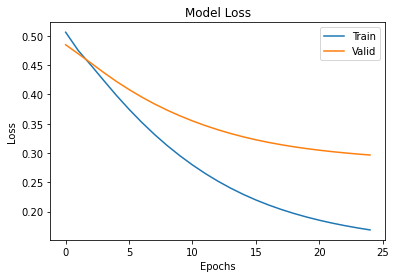

In [34]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

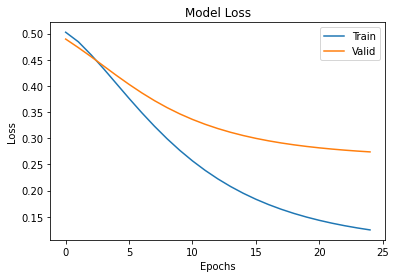

In [35]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

## **Predictions**

In [36]:
pred1_1=model1.predict(X_test)
pred1_2=model2.predict(X_test)

pred_1=model1.predict(X_train)
pred_2=model2.predict(X_train)

In [37]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+str(i)]
    pred1_1[:,:,index]=scaler.inverse_transform(pred1_1[:,:,index])
    pred_1[:,:,index]=scaler.inverse_transform(pred_1[:,:,index])
    
    pred1_2[:,:,index]=scaler.inverse_transform(pred1_2[:,:,index])
    pred_2[:,:,index]=scaler.inverse_transform(pred_2[:,:,index])
    
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

## *Compare the actual and the predicted value and calculate the MAE*

Now we will calculate the mean absolute error of all observations.

In [38]:
from sklearn.metrics import mean_absolute_error
 
for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,2):
    print("Day ",j,":")
    print("value : ", y_test[:,j-1,index]," prediction M1 : ", pred1_1[:,j-1,index] ,"prediction : ",pred1_2[:,j-1,index])
    print("MAE-1 : ",mean_absolute_error(y_test[:,j-1,index],pred1_1[:,j-1,index]),end=", ")
    print("MAE-2 : ",mean_absolute_error(y_test[:,j-1,index],pred1_2[:,j-1,index]))
  print()
  print()
  

Streaming output truncated to the last 5000 lines.
value :  [0.]  prediction M1 :  [0.25866294] prediction :  [0.24165305]
MAE-1 :  0.2586629390716553, MAE-2 :  0.24165305495262146


Severe
consolidation in the left lung
Day  1 :
value :  [0.]  prediction M1 :  [0.38247776] prediction :  [0.08274972]
MAE-1 :  0.3824777603149414, MAE-2 :  0.08274972438812256


her intra-aortic balloon
pump
Day  1 :
value :  [0.]  prediction M1 :  [0.18011978] prediction :  [0.4666626]
MAE-1 :  0.18011978268623352, MAE-2 :  0.46666258573532104


The varices
Day  1 :
value :  [0.]  prediction M1 :  [0.25383484] prediction :  [0.2959438]
MAE-1 :  0.2538348436355591, MAE-2 :  0.2959437966346741


CT scan of the
cervical spine
Day  1 :
value :  [0.]  prediction M1 :  [0.22056547] prediction :  [0.19732824]
MAE-1 :  0.22056546807289124, MAE-2 :  0.19732823967933655


Hypothyroidism
Day  1 :
value :  [0.]  prediction M1 :  [0.3423888] prediction :  [0.25292212]
MAE-1 :  0.3423888087272644, MAE-2 :  0.252922117

In [39]:
predictions = pd.DataFrame(columns=train_df.columns)

In [40]:
predictions

,Ceftriaxone,diabetic,Codeine,Known Allergies,neck pain,Erythromycin Base,rheumatoid disorder,Pneumonia,coronary artery disease,Compazine,Drugs,tingling,Penicillins,rheumatoid arthritis,syndrome,hypertension,Nausea,GI bleed,Difficulty breathing,Ischemic left foot,hypercholesterolemia,CLL to large B cell NHL,substernal chest pain,vomiting,Intubation,pain across the\r\r\nupper back,difficulty swallowing,Esophogealduodenoscopy,aortic stenosis,anterior tibial artery vein\r\r\n graft,polyarthritis,PNA,The pain,hepatitis B,EGD,any loss of consciousness,tracheal intubation\r\r\nchest tube placement\r\r\ncentral line placement,"Coronary artery bypass grafts (LIMA-OM,RIMA-RCA), Aortic\r\r\nvalve replacement",Arteriogram of the left lower extremity,muscle weakness,...,neurosurgery,intervention,Home antihypertensive,sepsis,home HCTZ,repeat\r\r\nvideo swallow,self caths,Albuterol,SOB,wheeze,HCTZ,Terazosin,Tiotropium,albuterol sulfate,shortness,hydrochlorothiazide,lisinopril,terazosin,tiotropium bromide,omeprazole,clindamycin HCl,acetaminophen,Robitussin Chest Congestion,Retropharyngeal space infection,Pneumonia/pleural effusion,Urinary tract infection,Atrial fibrillation\r\r\nC-spine fx,assistance,swelling,an infection,the infection,CAT scan of your neck,a pneumonia,some fluid in your lung,an antibiotic,a urinary tract infection,an\r\r\nantibiotic,an old\r\r\nsmall fracture in your neck,START Clindamycin,Tylenol


In [41]:
final = list()
for index,i in enumerate(train_df.columns):
  if pred1_1[:,0,index] >= 0.5:
    final.append(1)
  else :
    final.append(0)

predictions.loc[0] = final

In [42]:
predictions

,Ceftriaxone,diabetic,Codeine,Known Allergies,neck pain,Erythromycin Base,rheumatoid disorder,Pneumonia,coronary artery disease,Compazine,Drugs,tingling,Penicillins,rheumatoid arthritis,syndrome,hypertension,Nausea,GI bleed,Difficulty breathing,Ischemic left foot,hypercholesterolemia,CLL to large B cell NHL,substernal chest pain,vomiting,Intubation,pain across the\r\r\nupper back,difficulty swallowing,Esophogealduodenoscopy,aortic stenosis,anterior tibial artery vein\r\r\n graft,polyarthritis,PNA,The pain,hepatitis B,EGD,any loss of consciousness,tracheal intubation\r\r\nchest tube placement\r\r\ncentral line placement,"Coronary artery bypass grafts (LIMA-OM,RIMA-RCA), Aortic\r\r\nvalve replacement",Arteriogram of the left lower extremity,muscle weakness,...,neurosurgery,intervention,Home antihypertensive,sepsis,home HCTZ,repeat\r\r\nvideo swallow,self caths,Albuterol,SOB,wheeze,HCTZ,Terazosin,Tiotropium,albuterol sulfate,shortness,hydrochlorothiazide,lisinopril,terazosin,tiotropium bromide,omeprazole,clindamycin HCl,acetaminophen,Robitussin Chest Congestion,Retropharyngeal space infection,Pneumonia/pleural effusion,Urinary tract infection,Atrial fibrillation\r\r\nC-spine fx,assistance,swelling,an infection,the infection,CAT scan of your neck,a pneumonia,some fluid in your lung,an antibiotic,a urinary tract infection,an\r\r\nantibiotic,an old\r\r\nsmall fracture in your neck,START Clindamycin,Tylenol
0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##  *The List of the predictions*

In [43]:
predicted_result1 = list()
for index,i in enumerate(train_df.columns):
  if pred1_1[:,0,index] >= 0.5:
    predicted_result1.append(str(i))
predicted_result1

['Known Allergies',
 'coronary artery disease',
 'Drugs',
 'aortic stenosis',
 'Coronary artery bypass grafts (LIMA-OM,RIMA-RCA), Aortic\r\r\nvalve replacement',
 'Thrombectomy of left lower extremity common femoral\r\r\nartery to peroneal artery bypass vein graft',
 'surgery',
 'CAD',
 'serial arteriogram\r\r\nof the left lower extremity',
 'balloon angioplasty of the left\r\r\nfemoral artery',
 'peroneal artery bypass graft',
 'balloon\r\r\nangioplasty of the distal anastamosis',
 'elective\r\r\nresection',
 'radiation proctitis',
 'revision of R CFA',
 'CABG',
 'peroneal bypass graft',
 'GIB',
 'Heparin gtt',
 'colonoscopy',
 'prostate disease',
 'small polyps',
 'gastroesophageal reflux disease\r\r\nhypertension\r\r\nhyperlipidemia',
 'heparin gtt',
 'An echo',
 'coronary artery stenting',
 'critical aortic stenosis',
 'colon CA',
 'catheterization',
 'sudden cardiac death',
 '3VD',
 'respiratory distress',
 'NAD',
 'a flexible sigmoidoscopy',
 'Amiodarone',
 'the prior APC treatme

# Combine all the features and get one full prediction

In [78]:
result_expanded_v1 = df1["result1"].apply(pd.Series)
result_expanded_v2 = df1["result2"].apply(pd.Series)
result_expanded_v3 = df1["result3"].apply(pd.Series)
result_expanded_v4 = df1["result4"].apply(pd.Series)
result_expanded_v5 = df1["result5"].apply(pd.Series)

In [79]:
def get_uniques(result_expanded):
  a = [] 
  for i in range(0,len(result_expanded.columns)):
      a.extend((result_expanded[i].unique()))
  a = pd.DataFrame (a,columns=['a'])
  unique = a["a"].unique()
  return unique

In [80]:
#using the get_uniques function to get a list of all the features in each results column
unique1= get_uniques(result_expanded_v1)
unique2= get_uniques(result_expanded_v2)
unique3= get_uniques(result_expanded_v3)
unique4= get_uniques(result_expanded_v4)
unique5= get_uniques(result_expanded_v5)

In [81]:
result1_bool = boolean_df(df1["result1"], unique1)
result2_bool = boolean_df(df1["result2"], unique2)
result3_bool = boolean_df(df1["result3"], unique3)
result4_bool = boolean_df(df1["result4"], unique4)
result5_bool = boolean_df(df1["result5"], unique5)

In [82]:
result5_bool

,79,diabetic,55,49,hypertension,85,74,coronary artery disease,CAD,NIDDM,5U IV insulin,hypercholesterolemia,COPD former smoker 50 pack year,Coronary artery bypass grafts,hyperlipidemia,HTN,Hypertension,lopressor,aspirin,Dyslipidemia,Hyperlipidemia,continues to smoke,hypertensive,Coronary artery disease,norvasc,1/2,Lipitor,exertional\r\r\nchest pain,15,Labetalol,Quit smoking,AST-75,Hydrochlorothiazide,Baso-0 Atyps-0 Metas-0 Myelos-0,D1 80% ostial,nitroglycerin,VICU,nonsmoker.,CHLORIDE-99 TOTAL CO2-21,Non-insulin dependent-diabetes mellitus type 2,...,NSTEMI,GLUCOSE-269,propanolol,NamePattern1,STitle,Nipride,CHLORIDE-99,Nadolol,AMYLASE-65,Metoprolol,Lopressor,AMYLASE-59,Insulin,MCH-26.9,GLUCOSE-106,Name8,Breakfast Lunch Dinner Bedtime,HCTZ,Hapto-261,Name4,asa,atenolol,plavix,lipitor,RIMA-RCA,Clopidogrel,glipizide,NamePattern4,hydrochlorothiazide,Nifedipine,regular insulin,lisinopril,Plavix,Metoprolol Succinate,Amlodipine Besylate,Monday,Capital Home Care,2 vessel CABG,coronary artery disease\r\r\naortic stenosis\r\r\nperipheral vascular disease,"WEST,ROOM"
0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,...,0,0,0,1,1,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,1,0,1,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,1,0,1,1,0,0,0,1,0,1,0,1,0,1,1,0,1
3,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0
7,0,0,0,0,1,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [83]:
all_results = pd.concat([result1_bool, result2_bool, result3_bool, result4_bool, result5_bool], axis=1, join='inner')
all_results

,Ceftriaxone,diabetic,Codeine,Known Allergies,neck pain,Erythromycin Base,rheumatoid disorder,Pneumonia,coronary artery disease,Compazine,Drugs,tingling,Penicillins,rheumatoid arthritis,syndrome,hypertension,Nausea,GI bleed,Difficulty breathing,Ischemic left foot,hypercholesterolemia,CLL to large B cell NHL,substernal chest pain,vomiting,Intubation,pain across the\r\r\nupper back,difficulty swallowing,Esophogealduodenoscopy,aortic stenosis,anterior tibial artery vein\r\r\n graft,polyarthritis,PNA,The pain,hepatitis B,EGD,any loss of consciousness,tracheal intubation\r\r\nchest tube placement\r\r\ncentral line placement,"Coronary artery bypass grafts (LIMA-OM,RIMA-RCA), Aortic\r\r\nvalve replacement",Arteriogram of the left lower extremity,muscle weakness,...,NSTEMI,GLUCOSE-269,propanolol,NamePattern1,STitle,Nipride,CHLORIDE-99,Nadolol,AMYLASE-65,Metoprolol,Lopressor,AMYLASE-59,Insulin,MCH-26.9,GLUCOSE-106,Name8,Breakfast Lunch Dinner Bedtime,HCTZ,Hapto-261,Name4,asa,atenolol,plavix,lipitor,RIMA-RCA,Clopidogrel,glipizide,NamePattern4,hydrochlorothiazide,Nifedipine,regular insulin,lisinopril,Plavix,Metoprolol Succinate,Amlodipine Besylate,Monday,Capital Home Care,2 vessel CABG,coronary artery disease\r\r\naortic stenosis\r\r\nperipheral vascular disease,"WEST,ROOM"
0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,1,0,1,1,0,0,0,1,0,1,0,1,0,1,1,0,1
3,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0
7,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
8,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [84]:
all_results['date'] = pd.date_range(start='20/04/2021', periods=len(result1_bool), freq='D')

In [85]:
all_results = all_results.set_index('date')

In [86]:
all_results = all_results.loc[:,~all_results.columns.duplicated()]


In [87]:
all_results

,Ceftriaxone,diabetic,Codeine,Known Allergies,neck pain,Erythromycin Base,rheumatoid disorder,Pneumonia,coronary artery disease,Compazine,Drugs,tingling,Penicillins,rheumatoid arthritis,syndrome,hypertension,Nausea,GI bleed,Difficulty breathing,Ischemic left foot,hypercholesterolemia,CLL to large B cell NHL,substernal chest pain,vomiting,Intubation,pain across the\r\r\nupper back,difficulty swallowing,Esophogealduodenoscopy,aortic stenosis,anterior tibial artery vein\r\r\n graft,polyarthritis,PNA,The pain,hepatitis B,EGD,any loss of consciousness,tracheal intubation\r\r\nchest tube placement\r\r\ncentral line placement,"Coronary artery bypass grafts (LIMA-OM,RIMA-RCA), Aortic\r\r\nvalve replacement",Arteriogram of the left lower extremity,muscle weakness,...,continues to smoke,1/2,exertional\r\r\nchest pain,15,Quit smoking,AST-75,D1 80% ostial,VICU,nonsmoker.,CHLORIDE-99 TOTAL CO2-21,AlkPhos-96,UreaN-26,Cx had a 90%,113/77,MONOS-2.9,MEDQUIST36,RCA 70%,COUNT-357,IV insulin,8 R,lateral 80% stenosis in the med region of the vessel\r\r\nand a subbranch of the PL had a 70% stenosis at its origin.,Name11,former smoker,23/297,Pattern1,GLUCOSE-269,NamePattern1,STitle,CHLORIDE-99,AMYLASE-65,AMYLASE-59,MCH-26.9,GLUCOSE-106,Name8,Hapto-261,Name4,NamePattern4,Monday,Capital Home Care,"WEST,ROOM"
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-04-20,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2021-04-21,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0
2021-04-22,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,1,1
2021-04-23,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2021-04-24,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-04-25,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0
2021-04-26,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0,0,1,1,1,1,0,0
2021-04-27,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,...,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,1,0,0,0
2021-04-28,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [88]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os

## *Splitting the data into train and test*

In [89]:
train_df,test_df = all_results[0:38], all_results[1:39]

In [90]:
train_df

,Ceftriaxone,diabetic,Codeine,Known Allergies,neck pain,Erythromycin Base,rheumatoid disorder,Pneumonia,coronary artery disease,Compazine,Drugs,tingling,Penicillins,rheumatoid arthritis,syndrome,hypertension,Nausea,GI bleed,Difficulty breathing,Ischemic left foot,hypercholesterolemia,CLL to large B cell NHL,substernal chest pain,vomiting,Intubation,pain across the\r\r\nupper back,difficulty swallowing,Esophogealduodenoscopy,aortic stenosis,anterior tibial artery vein\r\r\n graft,polyarthritis,PNA,The pain,hepatitis B,EGD,any loss of consciousness,tracheal intubation\r\r\nchest tube placement\r\r\ncentral line placement,"Coronary artery bypass grafts (LIMA-OM,RIMA-RCA), Aortic\r\r\nvalve replacement",Arteriogram of the left lower extremity,muscle weakness,...,continues to smoke,1/2,exertional\r\r\nchest pain,15,Quit smoking,AST-75,D1 80% ostial,VICU,nonsmoker.,CHLORIDE-99 TOTAL CO2-21,AlkPhos-96,UreaN-26,Cx had a 90%,113/77,MONOS-2.9,MEDQUIST36,RCA 70%,COUNT-357,IV insulin,8 R,lateral 80% stenosis in the med region of the vessel\r\r\nand a subbranch of the PL had a 70% stenosis at its origin.,Name11,former smoker,23/297,Pattern1,GLUCOSE-269,NamePattern1,STitle,CHLORIDE-99,AMYLASE-65,AMYLASE-59,MCH-26.9,GLUCOSE-106,Name8,Hapto-261,Name4,NamePattern4,Monday,Capital Home Care,"WEST,ROOM"
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-04-20,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2021-04-21,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0
2021-04-22,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,1,1
2021-04-23,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2021-04-24,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-04-25,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0
2021-04-26,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0,0,1,1,1,1,0,0
2021-04-27,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,...,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,1,0,0,0
2021-04-28,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [91]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ str(i)] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+ str(i)]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ str(i)] = scaler
    test[i]=s_s

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel impor

## *Scaling and Reshaping*

In [92]:
test

,Ceftriaxone,diabetic,Codeine,Known Allergies,neck pain,Erythromycin Base,rheumatoid disorder,Pneumonia,coronary artery disease,Compazine,Drugs,tingling,Penicillins,rheumatoid arthritis,syndrome,hypertension,Nausea,GI bleed,Difficulty breathing,Ischemic left foot,hypercholesterolemia,CLL to large B cell NHL,substernal chest pain,vomiting,Intubation,pain across the\r\r\nupper back,difficulty swallowing,Esophogealduodenoscopy,aortic stenosis,anterior tibial artery vein\r\r\n graft,polyarthritis,PNA,The pain,hepatitis B,EGD,any loss of consciousness,tracheal intubation\r\r\nchest tube placement\r\r\ncentral line placement,"Coronary artery bypass grafts (LIMA-OM,RIMA-RCA), Aortic\r\r\nvalve replacement",Arteriogram of the left lower extremity,muscle weakness,...,continues to smoke,1/2,exertional\r\r\nchest pain,15,Quit smoking,AST-75,D1 80% ostial,VICU,nonsmoker.,CHLORIDE-99 TOTAL CO2-21,AlkPhos-96,UreaN-26,Cx had a 90%,113/77,MONOS-2.9,MEDQUIST36,RCA 70%,COUNT-357,IV insulin,8 R,lateral 80% stenosis in the med region of the vessel\r\r\nand a subbranch of the PL had a 70% stenosis at its origin.,Name11,former smoker,23/297,Pattern1,GLUCOSE-269,NamePattern1,STitle,CHLORIDE-99,AMYLASE-65,AMYLASE-59,MCH-26.9,GLUCOSE-106,Name8,Hapto-261,Name4,NamePattern4,Monday,Capital Home Care,"WEST,ROOM"
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-04-21,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
2021-04-22,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0
2021-04-23,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2021-04-24,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2021-04-25,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
2021-04-26,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0
2021-04-27,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,

In [93]:
n_past = 37     # n_past ==> no of past observations
n_future = 1   # n_future ==> no of future observations 
n_features = 2499  # n_features ==> no of features at each timestep in the data.

In [94]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))


In [95]:
X_train

array([[[ 1., -1., -1., ..., -1., -1., -1.],
        [-1.,  1.,  1., ..., -1., -1., -1.],
        [-1., -1.,  1., ..., -1.,  1.,  1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [ 1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ...,  1., -1., -1.]]])

In [96]:
y_train

array([[[-1., -1., -1., ..., -1., -1., -1.]]])

In [97]:
X_test, y_test = split_series(test.values, n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [98]:
y_test

array([[[-1., -1., -1., ..., -1., -1., -1.]]])

## *Creating the predictive Models*

In [101]:
#LSTM model 

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
model = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 37, 2499)]   0                                            
__________________________________________________________________________________________________
lstm_16 (LSTM)                  [(None, 37, 100), (N 1040000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_17 (LSTM)                  [(None, 100), (None, 80400       lstm_16[0][0]                    
__________________________________________________________________________________________________
repeat_vector_5 (RepeatVector)  (None, 1, 100)       0           lstm_17[0][0]                    
____________________________________________________________________________________________

Fitting the models and plot the results

In [102]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history=model.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

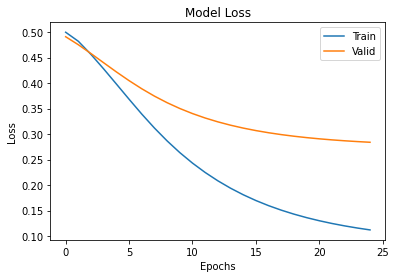

In [106]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

## **Predictions**

In [107]:
pred1=model.predict(X_test)

pred=model.predict(X_train)

In [108]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+str(i)]
    pred1[:,:,index]=scaler.inverse_transform(pred1[:,:,index])
    pred[:,:,index]=scaler.inverse_transform(pred[:,:,index])
        
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

## *Compare the actual and the predicted value and calculate the MAE*

In [109]:
from sklearn.metrics import mean_absolute_error
 
for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,2):
    print("Day ",j,":")
    print("value: ", y_test[:,j-1,index]," prediction: ", pred1[:,j-1,index])
    print("MAE : ",mean_absolute_error(y_test[:,j-1,index],pred1[:,j-1,index]),end=", ")
  print()
  print()
  

Streaming output truncated to the last 5000 lines.
C-spine fx
Day  1 :
value:  [0.]  prediction:  [0.14329019]
MAE :  0.1432901918888092, 

assistance
Day  1 :
value:  [0.]  prediction:  [0.3980222]
MAE :  0.39802220463752747, 

swelling
Day  1 :
value:  [0.]  prediction:  [0.1622661]
MAE :  0.1622661054134369, 

an infection
Day  1 :
value:  [0.]  prediction:  [0.2767176]
MAE :  0.2767176032066345, 

the infection
Day  1 :
value:  [0.]  prediction:  [0.43701863]
MAE :  0.43701863288879395, 

CAT scan of your neck
Day  1 :
value:  [0.]  prediction:  [0.21724018]
MAE :  0.21724018454551697, 

a pneumonia
Day  1 :
value:  [0.]  prediction:  [0.25566867]
MAE :  0.25566866993904114, 

some fluid in your lung
Day  1 :
value:  [0.]  prediction:  [0.14642647]
MAE :  0.1464264690876007, 

an antibiotic
Day  1 :
value:  [0.]  prediction:  [0.24383417]
MAE :  0.24383416771888733, 

a urinary tract infection
Day  1 :
value:  [0.]  prediction:  [0.3133484]
MAE :  0.3133484125137329, 

an
antibioti

In [110]:
predictions = pd.DataFrame(columns=train_df.columns)

In [111]:
predictions

,Ceftriaxone,diabetic,Codeine,Known Allergies,neck pain,Erythromycin Base,rheumatoid disorder,Pneumonia,coronary artery disease,Compazine,Drugs,tingling,Penicillins,rheumatoid arthritis,syndrome,hypertension,Nausea,GI bleed,Difficulty breathing,Ischemic left foot,hypercholesterolemia,CLL to large B cell NHL,substernal chest pain,vomiting,Intubation,pain across the\r\r\nupper back,difficulty swallowing,Esophogealduodenoscopy,aortic stenosis,anterior tibial artery vein\r\r\n graft,polyarthritis,PNA,The pain,hepatitis B,EGD,any loss of consciousness,tracheal intubation\r\r\nchest tube placement\r\r\ncentral line placement,"Coronary artery bypass grafts (LIMA-OM,RIMA-RCA), Aortic\r\r\nvalve replacement",Arteriogram of the left lower extremity,muscle weakness,...,continues to smoke,1/2,exertional\r\r\nchest pain,15,Quit smoking,AST-75,D1 80% ostial,VICU,nonsmoker.,CHLORIDE-99 TOTAL CO2-21,AlkPhos-96,UreaN-26,Cx had a 90%,113/77,MONOS-2.9,MEDQUIST36,RCA 70%,COUNT-357,IV insulin,8 R,lateral 80% stenosis in the med region of the vessel\r\r\nand a subbranch of the PL had a 70% stenosis at its origin.,Name11,former smoker,23/297,Pattern1,GLUCOSE-269,NamePattern1,STitle,CHLORIDE-99,AMYLASE-65,AMYLASE-59,MCH-26.9,GLUCOSE-106,Name8,Hapto-261,Name4,NamePattern4,Monday,Capital Home Care,"WEST,ROOM"


In [112]:
final = list()
for index,i in enumerate(train_df.columns):
  if pred1[:,0,index] >= 0.5:
    final.append(1)
  else :
    final.append(0)

predictions.loc[0] = final

In [113]:
predictions

,Ceftriaxone,diabetic,Codeine,Known Allergies,neck pain,Erythromycin Base,rheumatoid disorder,Pneumonia,coronary artery disease,Compazine,Drugs,tingling,Penicillins,rheumatoid arthritis,syndrome,hypertension,Nausea,GI bleed,Difficulty breathing,Ischemic left foot,hypercholesterolemia,CLL to large B cell NHL,substernal chest pain,vomiting,Intubation,pain across the\r\r\nupper back,difficulty swallowing,Esophogealduodenoscopy,aortic stenosis,anterior tibial artery vein\r\r\n graft,polyarthritis,PNA,The pain,hepatitis B,EGD,any loss of consciousness,tracheal intubation\r\r\nchest tube placement\r\r\ncentral line placement,"Coronary artery bypass grafts (LIMA-OM,RIMA-RCA), Aortic\r\r\nvalve replacement",Arteriogram of the left lower extremity,muscle weakness,...,continues to smoke,1/2,exertional\r\r\nchest pain,15,Quit smoking,AST-75,D1 80% ostial,VICU,nonsmoker.,CHLORIDE-99 TOTAL CO2-21,AlkPhos-96,UreaN-26,Cx had a 90%,113/77,MONOS-2.9,MEDQUIST36,RCA 70%,COUNT-357,IV insulin,8 R,lateral 80% stenosis in the med region of the vessel\r\r\nand a subbranch of the PL had a 70% stenosis at its origin.,Name11,former smoker,23/297,Pattern1,GLUCOSE-269,NamePattern1,STitle,CHLORIDE-99,AMYLASE-65,AMYLASE-59,MCH-26.9,GLUCOSE-106,Name8,Hapto-261,Name4,NamePattern4,Monday,Capital Home Care,"WEST,ROOM"
0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,...,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,1,0,0,0


##  *The List of the predictions*

In [114]:
predicted_result1 = list()
for index,i in enumerate(train_df.columns):
  if pred1[:,0,index] >= 0.5:
    predicted_result1.append(str(i))
predicted_result1

['Known Allergies',
 'coronary artery disease',
 'Drugs',
 'aortic stenosis',
 'Coronary artery bypass grafts (LIMA-OM,RIMA-RCA), Aortic\r\r\nvalve replacement',
 'Thrombectomy of left lower extremity common femoral\r\r\nartery to peroneal artery bypass vein graft',
 'surgery',
 'CAD',
 'serial arteriogram\r\r\nof the left lower extremity',
 'balloon angioplasty of the left\r\r\nfemoral artery',
 'peroneal artery bypass graft',
 'balloon\r\r\nangioplasty of the distal anastamosis',
 'elective\r\r\nresection',
 'radiation proctitis',
 'Right CFA aneurysm',
 'revision of R CFA',
 'CABG',
 'peroneal bypass graft',
 'GIB',
 'Heparin gtt',
 'colonoscopy',
 'prostate disease',
 'small polyps',
 'gastroesophageal reflux disease\r\r\nhypertension\r\r\nhyperlipidemia',
 'heparin gtt',
 'An echo',
 'coronary artery stenting',
 'critical aortic stenosis',
 'colon CA',
 'catheterization',
 'sudden cardiac death',
 '3VD',
 'respiratory distress',
 'NAD',
 'another GIB',
 'a flexible sigmoidoscopy',